# Simple Neural Network

Simple neural network es una librería escrita en python con fines didácticos.

En esta se encuentran implementados 3 tipos de sistemas neuronales como son:
* Clasificador binario.
* Clasificador multicalse.
* Redes neuronales multicapa.

Este notebook tiene como objetivo presentar la forma en la que están programados cada uno de los elementos de esta librería.

Se hará referencia a la ubicación de cada uno de los elementos dentro de la estructura de la librería de la siguiente forma: `simple_neural_network/package(s)/file.py`.
Siendo `simple_neural_network` la raíz de la librería.


## Dependencias

Definiremos en primer lugar las dependencias necesarias para poder utilizar esta liibrería y haremos distinción entre las que ya vienen por defecto con python y las que hay que descargar de forma explícita.

* Paquetes de python:
    * `csv`: dedicado a la lectura de datos desde ficheros csv.
    * `pickle`: utilizado para guardar y cargas los sistemas neuronales en disco y poder reutilizarlos.
    * `enum`: utilizado para la definición de enums, como por ejemplo los tipos de funciones de adtivación. De esta forma es más cómodo seleccionar una función u otra sin cometer errores, otra librerías utilizan strings.


* Paquetes externos:
    * `matplotlib`: utiliada para reprsentar información de forma gráfica.
    * `matplotlib`: esencial para trabajar con matrices y poder realiar operaciones con estas de una forma más cómda y eficiente.

In [5]:
import csv
import pickle
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np

## Constantes

Ubicación: `simple_neural_network/constants/constants.py`

Se crea este archivo para un manejo más sencillo y localizado de los valores constantes de los elementos que componen la librería.


In [6]:
# Utilities
OBJECTS_SAVED_EXTENSION = '.snn'

# Activation functions
STEP_FUNCTION_VALUE = 0

# Binary classifier
RATE_DEFAULT_VALUE = 1
MAX_ITERATIONS_DEFAULT_VALUE = 100

## Lectura de datos desde archivos CSV

Ubicación: `simple_neural_network/utilities/data_loader/csv_data_loader.py`

Una de las utilidades de la librería es un módulo para la lectura de datos desde archivos `.csv`, ya que estos achivos son muy comunes para la representación de sets de datos.

Se puede observar como se dispone de dos métodos públicos estáticos capaces de generar un array de numpy tanto para datos como para etiquetas. Siendo el tipo de datos de `np.double` y `np.intc` respectivamente.
Este array que devuelve cada método se generea a partir de los datos del archivo csv que se pasa como parámetro. Además de la ruta del archivo `.csv` que contiene los datos se deben intriducir dos parámetros más,
el delimitador utulizado para separar los datos y si queremos omitir la primera línea del archivo, ya que en muchos casos esta primera línea se trata de la cabecera de los mismos.

* Funciones:

    * `__load_data(path_to_csv_file, delimiter, discard_first_row)`: función privada encargada de leer el archivo `.csv` pasado como parámetro y devolver un lista de datos.
    * `load_samples(path_to_csv_file, delimiter, discard_first_row)`: función cabecera que realiza una llamada a `__load_data(path_to_csv_file, delimiter, discard_first_row)` para cargar los datos de las muestras y
    devolverlos en una lista de tipo `np.double`.
    * `load_labels(path_to_csv_file, delimiter, discard_first_row)`: función cabecera que realiza una llamada a `__load_data(path_to_csv_file, delimiter, discard_first_row)` para cargar los datos de las etiquetas y
    devolverlos en una lista de tipo `np.intc`.

    Parámetros:
        * `path_to_csv_file`: ruta al archivo `.csv` que se desea leer.
        * `delimiter`: caracter delimitador utilizado para separar los valores de los datos en el fichero `.csv`, usualmente son: `,` o `;`.
        * `discard_first_row`: booleano que indica si deseamos descartar o no la primera fila del archivo.


Las dimensiones del array de datos será NxM, siendo N el número de filas y M el número de columnas del archivo `.csv`.
Y Nx1 para el array de etiquetas.

Nótese como se elimina la primera línea del archivo `.csv`, ya que contiene la descripción de las columnas.

Ejemplo de uso:

`samples.csv`
```
# sepal_length, # petal_length
5.1, 1.4
4.9, 1.4
4.7, 1.3
4.6, 1.5
```
`CSVDataLoader.load_samples(samples.csv, ',', True)` -> [[5.1, 1.4], [4.9, 1.4], [4.7, 1.3], [4.6, 1.5]]

`labels.csv`
```
# labels (0 = Iris-setosa, 1 = Iris-versicolor)
0
0
0
0
```
`CSVDataLoader.load_labels(labels.csv, ',', True)` -> [[0], [0], [0], [0]]

In [7]:
class CSVDataLoader:

    @staticmethod
    def __load_data(path_to_csv_file, delimiter, discard_first_row):
        with open(path_to_csv_file) as samples_csv_file:
            data = csv.reader(samples_csv_file, delimiter=delimiter)

            data_list = []
            for row in data:
                data_list.append(row)

            if discard_first_row:
                data_list.pop(0)

            return data_list

    @staticmethod
    def load_samples(path_to_csv_file, delimiter, discard_first_row):
        return np.array(CSVDataLoader.__load_data(path_to_csv_file, delimiter, discard_first_row), dtype=np.double)

    @staticmethod
    def load_labels(path_to_csv_file, delimiter, discard_first_row):
        return np.array(CSVDataLoader.__load_data(path_to_csv_file, delimiter, discard_first_row), dtype=np.intc)

## Guardado y carga de sistemas neuronales

Ubicación: `simple_neural_network/utilities/neural_systems_picker/neural_systems_picker.py`

Otra utilidad implementada es la de guardado y carga de sistemas neuronales. Para ello se definen dos métodos estáticos para el guardado y la carga de sistema neuronales en disco.
Se puede observar como la extensión de los archivos queda definida en la constante `OBJECTS_SAVED_EXTENSION = '.snn'`.

Esto nos permite reutilizar redes ya entrenenadas para hacer un uso más eficiente de las mismas.

* Funciones:

    * `save_neural_system(file_name, neural_system)`: función encargada de guardar el sistema neuronal pasado como parámetro en disco.

    Parámetros:
        * `file_name`: ruta al archivo `.snn` donde se guardará el sistema neuronal.
        * `neural_system`: sistema neuronal a guardar.

    * `load_neural_system(file_name)`: función encargada de cargar el archivo que se encuntra en la ruta `file_name` como un sistema neuronal en memoria.

    Parámetros:
        * `file_name`: ruta al archivo `.snn` que se dese cargar como sistema neuronal.


In [8]:
class NeuralSystemPicker:

    @staticmethod
    def save_neural_system(file_name, neural_system):
        file = open(file_name + OBJECTS_SAVED_EXTENSION, 'wb')
        pickle.dump(neural_system, file)

    @staticmethod
    def load_neural_system(file_name):
        file = open(file_name, 'rb')
        return pickle.load(file)

## Enums

Ubicación: `simple_neural_network/activation_functions/activation_functions_enum.py`

En este archivo se definen los diferentes tipos de funciones de activación, una forma más cómoda de trabajar en lugar de utilizar strings o ints para su identificación.

Su uso se realiza de la sguiente forma: `ActivationFunctionsEnum.STEP_FUNCTION`

In [9]:
class ActivationFunctionsEnum(Enum):
    STEP_FUNCTION = 1
    IDENTITY_FUNCTION = 2

## Perceptrón

Ubicación: `simple_neural_network/neuron/neuron.py`

La clase `Neuron` es el elemento principal de esta librería, ya que formará parte de todos los sistemas neuronales que se definirán a continuación.

Elementos que componen la clase neurona:

* Constructor:

    * `Neuron(number_of_inputs, activation_function)`: constructor de un objeto de tipo `Neuron`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).
        Al número de entradas se le añade una extra de valor igual a 1 que hace referencia a la constante que multiplica al bias de los pesos.
        * `activation_function`: tipo de función de activación.

* Aributos:

    * `__weights`: representan los pesos de la neurona.
    * `__activation_function`: hace referencia al tipo de función de activación definida para la neurona. Siendo un valor del enum `ActivationFunctionsEnum` definido anteriomente.

* Funciones:

    * `weights()`: getter del atributo `__weights`.
    * `weights(value)`: setter del atributo `__weights`.

        Parámetros:
        * `value`: valor asigando al atributo `__weights`.

    * `activation_function()`: getter del atributo `__activation_function`. En este caso no se define un setter ya que la creación de este atributo se realiza en el constructor
    y no debe cambiar durante la ejecución del programa.
    * `__calculate_propagation(input_values)`: función de propagación de los valores de entrada y los pesos de la neurona. En este caso se trata del producto escalar entre ambos vectores.
    Es un método privado ya que solo debe hacer uso de este la función `calculate_output(input_values)`.

        Parámetros:
        * `input_values`: valores de entrada (muestra) sobre los que aplicar la regla de propagación junto a los pesos de la neurona.

    * `calculate_output(input_values)`: función de activación de la neurona, encargada de calcular la salida de esta en función del tipo de función de activación definida en el constructor.

        Parámetros:
        * `input_values`: valores de entrada (muestra) sobre los que obtener el valor de salida por la neurona.

In [10]:
class Neuron:

    def __init__(self, number_of_inputs, activation_function):
        self.__weights = np.random.random(number_of_inputs + 1)
        self.__activation_function = activation_function

    @property
    def weights(self):
        return self.__weights

    @weights.setter
    def weights(self, value):
        self.__weights = value

    @property
    def activation_function(self):
        return self.__activation_function

    def __calculate_propagation(self, input_values):
        return np.dot(self.weights, input_values)

    def calculate_output(self, input_values):
        input_values = np.append(1, input_values)
        if self.activation_function is ActivationFunctionsEnum.STEP_FUNCTION:
            return np.heaviside(self.__calculate_propagation(input_values), STEP_FUNCTION_VALUE)
        elif self.activation_function is ActivationFunctionsEnum.IDENTITY_FUNCTION:
            return self.__calculate_propagation(input_values)

## Clasificador binario

Ubicación: `simple_neural_network/neural_systems/binary_classifier/binary_classifier.py`

Es el primer sistema neuronal definido dado que es el más básico y que menos elementos requiere. Este sistema es capaz de definir una frontera lineal entre dos clases.

Elementos que componen al clasificador binario:

* Constructor:

    * `BinaryClassifier(number_of_inputs)`: constructor de un objeto de tipo `BinaryClassifier`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).

* Atributos:

    * `__neuron`: atributo de tipo `Neuron` definido anteriormente, es el encargado de realizar la clasificación y el objeto de entrenamiento.
    * `__rate`: atributo que define la velocidad de aprendizaje del algoritmo, valores próximos a cero suponen convergencias más suaves pero con más iteraciones. Por defecto su valor es 1, `RATE_DEFAULT_VALUE = 1`.
    * `__max_iterations`: atributo que define la cantidad máxima de iteraciones que realizará el algoritmo en caso de que las muestras no sean linealmente separables, por defecto su valor es 100 `MAX_ITERATIONS_DEFAULT_VALUE = 100`.
    * `__miss_classified_samples_per_iteration`: es una lista donde cada elemento corresponde al número de muestras mal clasificadas en la iteración pos + 1 de la lista.
    Es decir `__miss_classified_samples_per_iteration[x]` corresponde al número de muestras mal clasificadas en la iteración x + 1.

* Funciones:

    * `rate()`: getter del atributo `__rate`. En este caso no se define un setter ya que la definición de este atributo se realiza en el método `train(rate, max_iterations)` y no debe cambiar durante la ejecución.
    * `max_iterations()`: getter del atributo `__max_iterations`. En este caso no se define un setter ya que la definición de este atributo se realiza en el método `train(rate, max_iterations)` y no debe cambiar durante la ejecución.
    * `miss_classified_samples_per_iteration()`: getter del atributo `__miss_classified_samples_per_iteration`. En este caso no se define un setter ya que este atributo se genera en tiempo de ejecución.
    * `iterations()`: esta función nos devuelve el número total iteraciones realizadas durante el proceso de entrenamiento. Su valor se obtiene de la dimensión del atributo `__miss_classified_samples_per_iteration`.
    * `weights()`: getter del atributo `__neuron.weights()` definido en la clase `Neuron`.
    * `train(samples, labels, rate, max_iterations)`: función encargada de realizar el entrenamiento del sistema, el algoritmo utilizado es el del perceptrón con la modalidad del atributo rate para la velocidad de entrenamiento.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

        * `rate`: velocidad de aprendizaje del algoritmo.
        * `max_iterations`: número máximo de iteraciones del algoritmo.

    Se puede observar como el algoritmo se ejecuta hasta que o bien haya clasificado correctamente todas las muestras en una misma iteración o se alcance el máximo número de iteraciones.

    * `classify(sample)`: función encargada de clasificar una muestra, de vuelve 0 o 1.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `calculate_error(samples, labels):`: función encargada de calcular el porcentaje de error cometido por el sistema al clasificar las muestras entregadas como parámetros con sus respectivas etiquetas.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

In [11]:
class BinaryClassifier:

    def __init__(self, number_of_inputs):
        self.__neuron = Neuron(number_of_inputs, ActivationFunctionsEnum.STEP_FUNCTION)
        self.__rate = RATE_DEFAULT_VALUE
        self.__max_iterations = MAX_ITERATIONS_DEFAULT_VALUE
        self.__miss_classified_samples_per_iteration = []

    @property
    def rate(self):
        return self.__rate

    @property
    def max_iterations(self):
        return self.__max_iterations

    @property
    def miss_classified_samples_per_iteration(self):
        return self.__miss_classified_samples_per_iteration

    @property
    def iterations(self):
        return len(self.__miss_classified_samples_per_iteration)

    @property
    def weights(self):
        return self.__neuron.weights

    def train(self, samples, labels, rate, max_iterations):
        self.__rate = rate
        self.__max_iterations = max_iterations
        iteration = 0

        while True:
            well_classified_samples = 0
            miss_classified_samples = 0

            for sample, label in zip(samples, labels):
                error = label - self.__neuron.calculate_output(sample)
                if error != 0:
                    self.__neuron.weights += (self.rate * error * np.append(1, sample))
                    miss_classified_samples += 1
                else:
                    well_classified_samples += 1

            iteration += 1
            self.miss_classified_samples_per_iteration.append(miss_classified_samples)

            if iteration == self.max_iterations or well_classified_samples == samples.shape[0]:
                break

    def classify(self, sample):
        return self.__neuron.calculate_output(sample)

    def calculate_error(self, samples, labels):
        errors = 0

        for sample, label in zip(samples, labels):
            if self.classify(sample) != label[0]:
                errors += 1

        return errors / len(labels)

## Ejemplo de uso del clasificador binario

Ubicación: `usage_binary_classifier.py`

Uso: `python src/usage_binary_classifier.py`

En este archivo se realiza un ejemplo de uso del clasificador binario con un set de datos real como es el de iris-setosa e iris-versicolor.
Se dispone de cuatro archivos .csv en el directorio `/data/iris_virginica` estos archivos contienen la longitud de pétalos y sépalos de cada tipo de flor y su clase:

* `iris_virginica_train_60_samples.csv` e `iris_virginica_train_60_labels.csv` son las muestras y etiquetas utilizadas para el entrenamiento del sistema.
* `iris_virginica_test_40_samples.csv` e `iris_virginica_test_40_labels.csv` son las muestras y etiquetas utilizadas para el porcentaje de error obtenido por el sistema una vez entrenado.

En primer lugar se cargan los datos `train_samples`, `train_labels`, `train_labels` y `test_labels` haciendo uso de `CSVData`.

Instanciamos un `BinaryClassifier(train_samples.shape[1])`, donde `train_samples.shape[1] = dimensión de la primera muestra = 2` y lo entrenamos con `binary_classifier.train(train_samples, train_labels, 0.8, 20)` con un `rate = 0.8` y `max_iterations = 20`.

Calculamos el error obtenido por el sistema haciendo uso de la función `binary_classifier.calculate_error(test_samples, test_labels)` y lo mostramos por consola.

Tras entrenar el sistema y a modo de ejemplo, lo guardamos en disco `NeuralSystemsPicker.save_neural_system('./serialized_objects/binary_classifier', binary_classifier)`
y lo volvemos a cargar `binary_classifier = NeuralSystemsPicker.load_neural_system('./serialized_objects/binary_classifier.snn')`.

Por último representamos los datos obtenidos:
* En primer lugar imprimimos las muestras y la intersección del hiperplano generado por el clasificador con el plano XY para Z = 0.
* Por último imprimimos el número de errores por iteración obtenidos durante el entrenamiento.

0.0


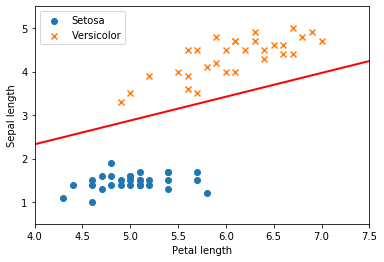

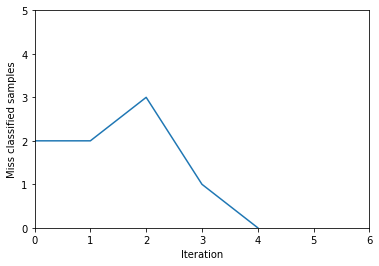

In [12]:
train_samples = CSVDataLoader.load_samples('./data/iris_virginica/iris_virginica_train_60_samples.csv', ',', True)
train_labels = CSVDataLoader.load_labels('./data/iris_virginica/iris_virginica_train_60_labels.csv', ',', True)
test_samples = CSVDataLoader.load_samples('./data/iris_virginica/iris_virginica_train_60_samples.csv', ',', True)
test_labels = CSVDataLoader.load_labels('./data/iris_virginica/iris_virginica_train_60_labels.csv', ',', True)

binary_classifier = BinaryClassifier(train_samples.shape[1])
binary_classifier.train(train_samples, train_labels, 0.8, 20)

print('BinaryClassifier system error:' + binary_classifier.calculate_error(test_samples, test_labels))

NeuralSystemPicker.save_neural_system('./serialized_objects/binary_classifier', binary_classifier)
binary_classifier = NeuralSystemPicker.load_neural_system('./serialized_objects/binary_classifier.snn')

plt.scatter(np.array(train_samples[:30, 0]), np.array(train_samples[:30, 1]), marker='o', label='Setosa')
plt.scatter(np.array(train_samples[30:, 0]), np.array(train_samples[30:, 1]), marker='x', label='Versicolor')
plt.xlabel('Petal length')
plt.ylabel('Sepal length')
plt.legend()

weights = binary_classifier.weights
x = np.linspace(4, 7.5, 100)
y = (-1) * (weights[1] * x + weights[0]) / weights[2]
plt.plot(x, y, '-r', linewidth=2)

axes = plt.gca()
axes.set_xlim(4, 7.5)
axes.set_ylim(0.5, 5.5)
plt.show()

plt.plot(binary_classifier.miss_classified_samples_per_iteration)
plt.axis([0, 6, 0, 5])
plt.ylabel('Miss classified samples')
plt.xlabel('Iteration')
plt.show()

## Clasificador multiclase

Ubicación: `simple_neural_network/neural_systems/multiclass_classifier/multiclass_classifier.py`

Este sistema es capaz de clasificar una serie de muestras en N clases diferentes, haciendo uso de N neuronas para ello.
Al igual que ocurría con el clasificador binario, la frontera de decisión entre dos clases sigue siendo lineal.

Elementos que componen al clasificador binario:

* Constructor:

    * `MulticlassClassifier(number_of_inputs, number_of_classes)`: constructor de un objeto de tipo `MulticlassClassifier`.

        Parámetros:
        * `number_of_inputs`: entero que indica el número de entradas de la neurona (dimensión de las muestras).
        * `number_of_classes`: entero que indica el número de clases del sistema.

* Atributos:

    * `__number_of_classes`: atributo de tipo entero que indica el número de clases del sistema.
    * `__neurons`: lista con objetos de tipo `Neuron` cuya dimensión es igual al número de clases del sistema.
    Cada una de estas neuronas será la responsable de realizar la clasificación de cada muestra en cada una de las diferentes clases.
    * `__rate`: atributo que define la velocidad de aprendizaje del algoritmo, valores próximos a cero suponen convergencias más suaves pero con más iteraciones. Por defecto su valor es 1, `RATE_DEFAULT_VALUE = 1`.
    * `__max_iterations`: atributo que define la cantidad máxima de iteraciones que realizará el algoritmo en caso de que las muestras no sean linealmente separables, por defecto su valor es 100 `MAX_ITERATIONS_DEFAULT_VALUE = 100`.
    * `__miss_classified_samples_per_iteration`: es una lista donde cada elemento corresponde al número de muestras mal clasificadas en la iteración pos + 1 de la lista.
    Es decir `__miss_classified_samples_per_iteration[x]` corresponde al número de muestras mal clasificadas en la iteración x + 1.

* Funciones:

    * `number_of_classes()`: getter del atributo `__number_of_classes`. En este caso no se define un setter ya que la definición de este atributo se realiza en el constructor y no debe cambiar durante la ejecución.
    * `rate()`: getter del atributo `__rate`. En este caso no se define un setter ya que la definición de este atributo se realiza en el método `train(rate, max_iterations)` y no debe cambiar durante la ejecución.
    * `max_iterations()`: getter del atributo `__max_iterations`. En este caso no se define un setter ya que la definición de este atributo se realiza en el método `train(rate, max_iterations)` y no debe cambiar durante la ejecución.
    * `miss_classified_samples_per_iteration()`: getter del atributo `__miss_classified_samples_per_iteration`. En este caso no se define un setter ya que este atributo se genera en tiempo de ejecución.
    * `iterations()`: esta función nos devuelve el número total iteraciones realizadas durante el proceso de entrenamiento. Su valor se obtiene de la dimensión del atributo `__miss_classified_samples_per_iteration`.
    * `weights()`: devuelve una lista con los pesos de cada una de las neuronas del atributo `__neurons`.
    * `train(samples, labels, rate, max_iterations)`: función encargada de realizar el entrenamiento del sistema, el algoritmo utilizado es el del perceptrón con la modalidad del atributo rate para la velocidad de entrenamiento.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

        * `rate`: velocidad de aprendizaje del algoritmo.
        * `max_iterations`: número máximo de iteraciones del algoritmo.

    El algoritmo corrige tanto los pesos de cada neurona que provoca error como el de la neurona que debría haber clasificado correctamente la muestra.
    Este algoritmo se ejecuta hasta que o bien haya clasificado correctamente todas las muestras en una misma iteración o se alcance el máximo número de iteraciones.

    * `classify(sample)`: función encargada de clasificar una muestra, de vuelve 0 o 1.

        Parámetros:
        * `sample`: un `np.array` de tipo `np.double` que representa una a una muestra.

    * `calculate_error(samples, labels):`: función encargada de calcular el porcentaje de error cometido por el sistema al clasificar las muestras entregadas.

        Parámetros:
        * `samples`: un `np.array` de tipo `np.double` para las muestras.
        * `labels`: un `np.array` de tipo `np.intc` para las etiquetas.
        Las muestras tendrán una dimensión NxM y las etiquetas Nx1 donde N hace referencia al número de muestras, y donde la etiqueta label[x] es la correspondiente a la muestra sample[x].

In [13]:
class MulticlassClassifier:

    def __init__(self, number_of_inputs, number_of_classes):
        self.__number_of_classes = number_of_classes
        self.__neurons = [Neuron(number_of_inputs, ActivationFunctionsEnum.IDENTITY_FUNCTION)
                          for _ in range(number_of_classes)]
        self.__rate = RATE_DEFAULT_VALUE
        self.__max_iterations = MAX_ITERATIONS_DEFAULT_VALUE
        self.__miss_classified_samples_per_iteration = []

    @property
    def number_of_classes(self):
        return self.__number_of_classes

    @property
    def rate(self):
        return self.__rate

    @property
    def max_iterations(self):
        return self.__max_iterations

    @property
    def miss_classified_samples_per_iteration(self):
        return self.__miss_classified_samples_per_iteration

    @property
    def iterations(self):
        return len(self.__miss_classified_samples_per_iteration)

    @property
    def weights(self):
        return [neuron.weights for neuron in self.__neurons]

    def train(self, samples, labels, rate, max_iterations):
        self.__rate = rate
        self.__max_iterations = max_iterations
        iteration = 0

        while True:
            well_classified_samples = 0
            miss_classified_samples = 0

            for sample, label in zip(samples, labels):

                well_classifier_value = self.__neurons[label[0]].calculate_output(sample)
                error = False

                for classifier in [classifier for classifier in range(self.number_of_classes)
                                   if classifier != label[0]]:
                    wrong_classifier_value = self.__neurons[classifier].calculate_output(sample)

                    if wrong_classifier_value > well_classifier_value:
                        self.__neurons[classifier].weights -= (self.rate * np.append(1, sample))
                        error = True

                    if error:
                        self.__neurons[label[0]].weights += (self.rate * np.append(1, sample))

                if error:
                    miss_classified_samples += 1
                else:
                    well_classified_samples += 1

            iteration += 1
            self.miss_classified_samples_per_iteration.append(miss_classified_samples)

            if iteration == self.max_iterations or well_classified_samples == samples.shape[0]:
                break

    def classify(self, sample):
        results = [neuron.calculate_output(sample) for neuron in self.__neurons]
        return results.index(max(results))

    def calculate_error(self, samples, labels):
        errors = 0

        for sample, label in zip(samples, labels):
            if self.classify(sample) != label[0]:
                errors += 1

        return errors / len(labels)

## Ejemplo de uso del clasificador multiclase

Ubicación: `usage_multiclass_classifer.py`

Uso: `python src/usage_multiclass_classifer.py`

En este archivo se realiza un ejemplo de uso del clasificador multiclase con un set de datos real como es el de mnist.
Se dispone de cuatro archivos .csv en el directorio `/data/iris_virginica` estos archivos contienen los valores de las imágenes de 28 x 28 píxeles en escala de grises de los dígitos manuscritos comprendidos entre el 0 y el 9, ambos inclusive:

* `mnist_train_60K_samples.csv` e `mnist_train_60K_labels.csv` son las muestras y etiquetas utilizadas para el entrenamiento del sistema.
* `mnist_test_10K_samples.csv` e `mnist_test_10K_labels.csv` son las muestras y etiquetas utilizadas para el porcentaje de error obtenido por el sistema una vez entrenado.

En primer lugar se cargan los datos `train_samples`, `train_labels`, `train_labels` y `test_labels` haciendo uso de `CSVData`.

Instanciamos un `MulticlassClassifier(train_samples.shape[1], 10)`, donde `train_samples.shape[1] = dimensión de la primera muestra = 784` y `10` es el número de clases diferentes
Entrenamos el sistema con `multiclass_classifier.train(train_samples, train_labels, 0.5, 20)` con un `rate = 0.5` y `max_iterations = 20`.

Calculamos el error obtenido por el sistema haciendo uso de la función `multiclass_classifier.calculate_error(test_samples, test_labels)` y lo mostramos por consola.

In [14]:
train_samples = CSVDataLoader.load_samples('./data/mnist/mnist_train_40K_samples.csv', ';', False)
train_labels = CSVDataLoader.load_labels('./data/mnist/mnist_train_40K_labels.csv', ';', False)
test_samples = CSVDataLoader.load_samples('./data/mnist/mnist_test_10K_samples.csv', ';', False)
test_labels = CSVDataLoader.load_labels('./data/mnist/mnist_test_10K_labels.csv', ';', False)

multiclass_classifier = MulticlassClassifier(train_samples.shape[1], 10)
multiclass_classifier.train(train_samples, train_labels, 0.5, 20)

print(multiclass_classifier.calculate_error(test_samples, test_labels))

20
[8239, 6993, 6795, 6779, 6732, 6710, 6690, 6688, 6686, 6660, 6657, 6653, 6646, 6631, 6624, 6644, 6628, 6631, 6634, 6624]
0.109
